# Clustering pipeline for JunoCam images
Given a JunoCam image, we want to be able to segregate the different types by color. With this, the goal is to produce useful statistics on the presence of different cloud classes at different locations and relate the cloud type to the dynamics of that region. 

To begin, first import the `ImageCluster` class which will be the main driver for this task

In [1]:
%load_ext autoreload

In [9]:
%autoreload 2
import clustering
import numpy as np
import matplotlib.pyplot as plt

This class is initialized with just the raw map-projected JunoCam image (see the example in `projection.ipynb` on how to do this).

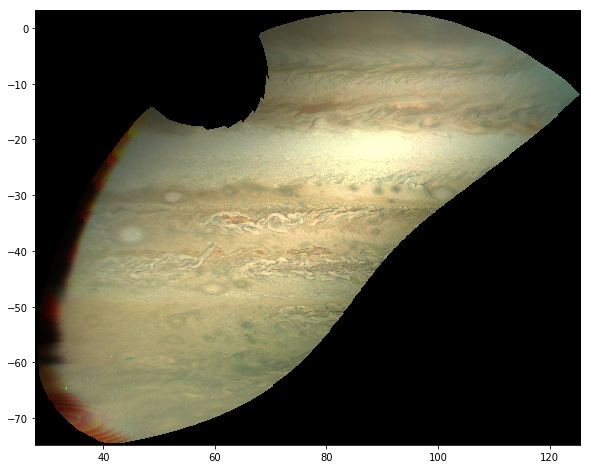

In [3]:
clust = clustering.cluster.ImageCluster('JNCE_2018302_16C00024_V01_proj.nc')

Do the clustering using the KMeans method. The input arguments are:

* `n_clusters`: The number of clusters to detect

* `source`: Either 'rgb' or 'hsv'. With RGB we can cluster raw pixel values, or with HSV, we can cluster colors directly. 

* `axis`: Tuple of length 2, that defines the two components to cluster. e.g. using RGB, (0,1) would be R and G, while with HSV, (0,1) would be Hue vs. Saturation

* arguments to be passed into the `KMeans` class

In [4]:
clust.create_clusters(n_clusters=5)

Once the clustering is done, we can plot some useful info

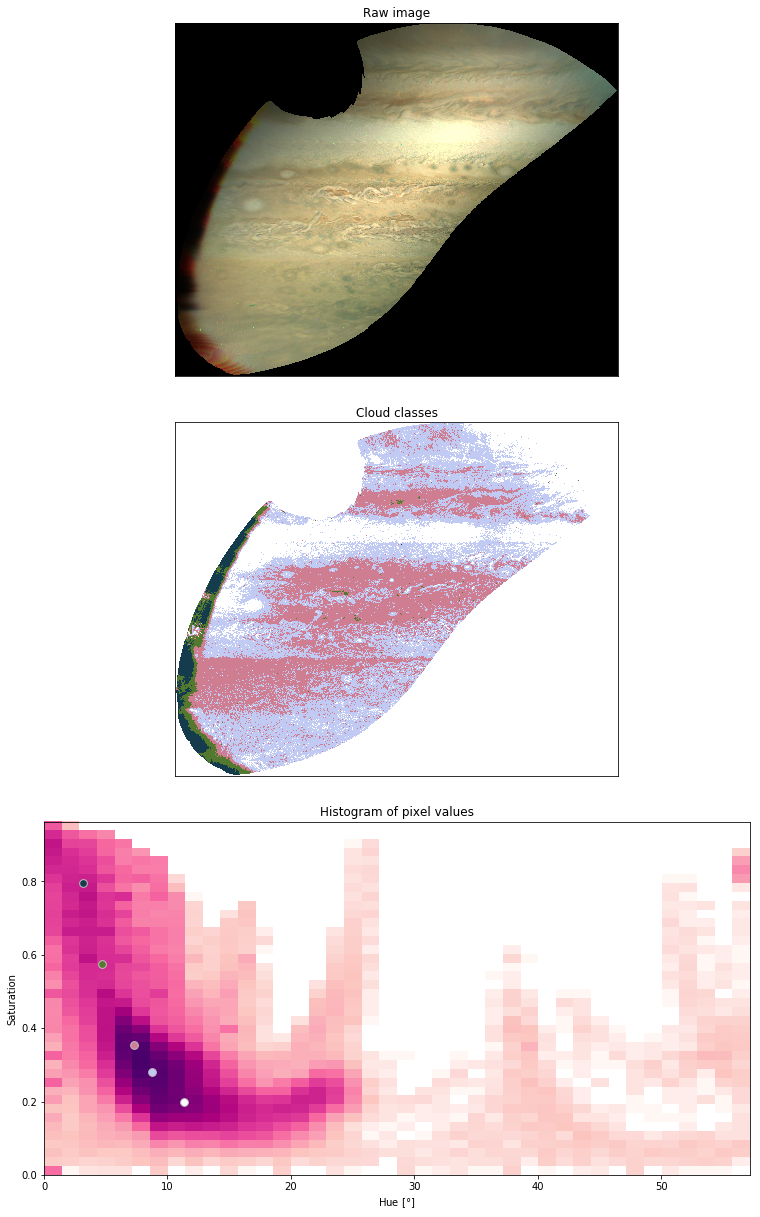

In [5]:
clust.plot_clusters()

Notice how the dark green classes are actually being detected on the interpolation errors. These are not useful for us, so we can remove them. The cluster labels are ordered from dark to light, starting from 1 to `n_clusters` defined above. They are also ordered in increasing $x$. So we want to remove the pixels associated with `label=1`. We can do this using the `filter_cluster` method:

In [6]:
clust.filter_cluster(1)

Removed 256741 pixels


Now, rerun again with the removed data:

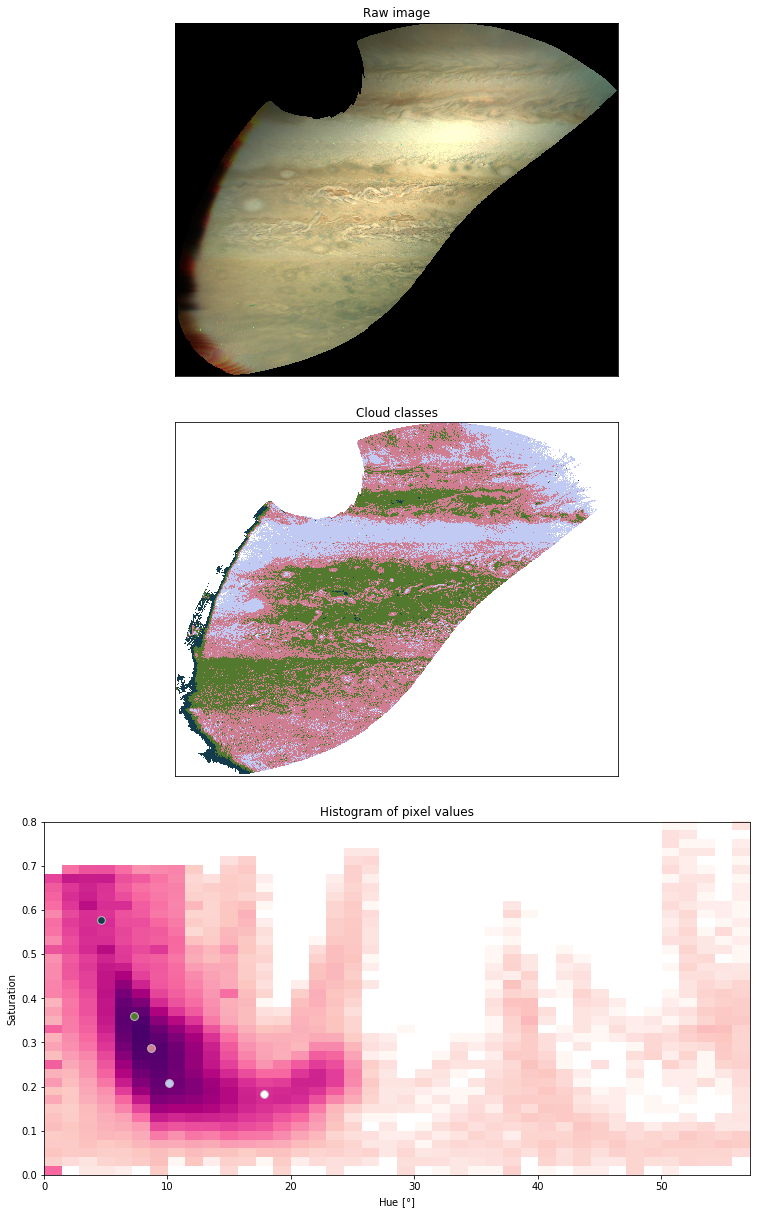

In [7]:
clust.create_clusters(n_clusters=5)
clust.plot_clusters()

Time to do some statistics. We can look at the correlation between cloud class and latitude. This will highlight the different bands on Jupiter

Text(0.5,0,'Zonal wind speed [m/s]')

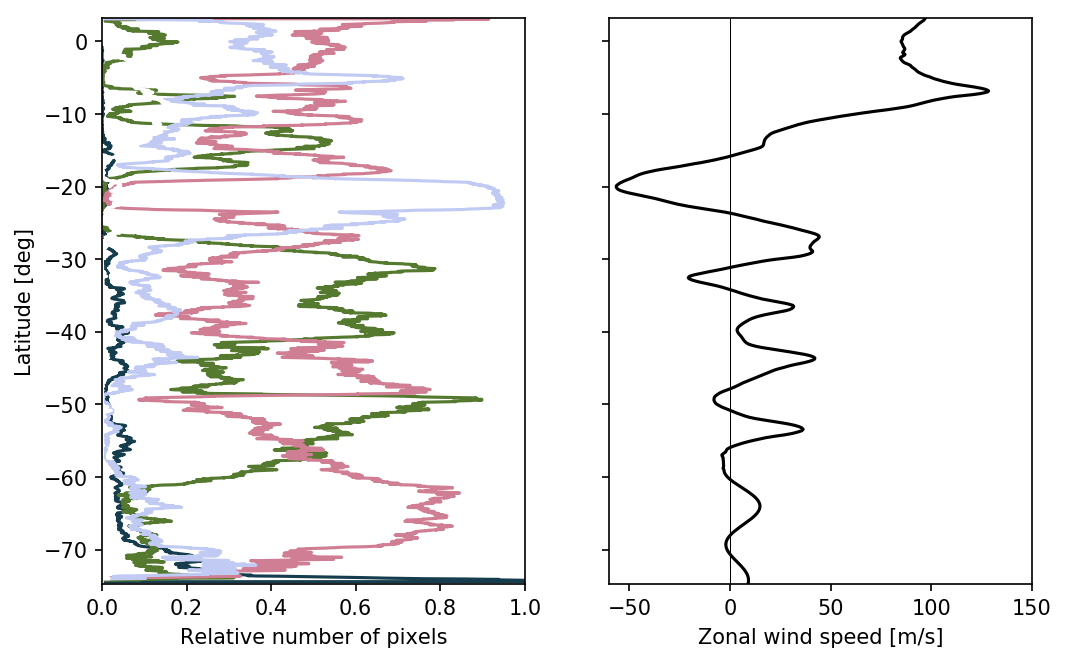

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True, dpi=150)

cmap = plt.cm.cubehelix(np.linspace(0, 1, clust.nlabels+1))

## we need to extract the number of pixels per latitude band per label
## and scale it down by the number of pixels per band
lat = clust.latflat[clust.pixmask]

## first extract the list of indices that correspond to each latitude

## sort the latitude index first so that we can get 
## sucessive latitude values
sorted_lat_ind   = np.argsort(lat)
sorted_lat       = lat[sorted_lat_ind]

## fetch the unique latitude values and their corresponding indices
latunique, ind_first, nlats = np.unique(sorted_lat, return_counts=True, return_index=True)

## finally split the index array by first index of each unique latitude point
lat_indices = np.split(sorted_lat_ind, ind_first[1:])

## create the array to hold the new data
data  = np.zeros((clust.lat.size, clust.nlabels))

## cycle through each unique latitude
for i, lati in enumerate(lat_indices):
    ## fetch the index that corresponds to the latitude grid
    lat_index = np.where(clust.lat == lat[lati[0]])[0]
    
    nlati     = nlats[i]
    
    ## then for each label, get the number of labels at
    ## this latitude value, scaled by nlat
    for j in range(clust.nlabels):
        data[lat_index,j] = np.sum(clust.labels[lati] == j+1)/nlati

## plot it out with the same colorscheme as before
for j in range(clust.nlabels):
    axs[0].plot(data[:,j], clust.lat, '-', color=cmap[j+1])
    
axs[0].set_xlim((0, 1))
axs[0].set_ylim((clust.lat.min(), clust.lat.max()))

## we want to compare this with the zonal wind
## the zonal wind is usually what drives dynamic variability and 
## is "responsible" for the jovian cloud bands
u_lat_jupiter = np.loadtxt('u_vs_lat.jupiter', skiprows=7)

## plot the zonal wind and highlight the zeros
axs[1].plot(u_lat_jupiter[:,1], u_lat_jupiter[:,0], 'k-')
axs[1].axvline(0., color='k', linewidth=0.5)

axs[1].set_xlim((-60., 150.))

axs[0].set_ylabel(r"Latitude [deg]")
axs[0].set_xlabel(r"Relative number of pixels")
axs[1].set_xlabel(r"Zonal wind speed [m/s]")